# Lab-7: ANN in Keras

In this lab, you will practice simple deep learning model in Pytorch.


## Objectives:
1. Theoretical issues
2. Get starting in Pytorch
___

### Theoretical issues
Ordinary fully connected neural nets consists of Dense layers, activations, and output layer.

1. What's the difference between deep learning and normal machine learning?
<span style="color:blue"> 1- Adding more data for traditional ML algorithms, won't improve
	  the performance and the learning curve will saturate (plateau), but for DL, you can get better performance.
	<br/>2- There's no feature extraction step in a lot of cases like in CNN
	<br/>3- It need high computational power in training.
2. How does a neural network with no hidden layers and one output neuron compare to a logistic/linear regression?
<span style="color:blue"> There's no difference. NN with no hidden layers is perceptron which has the same architecture of logistic/linear regression. If the activation function in the output layer is linear and loss is mse then it is linear regression. If the activation function in the output layer is sigmoid and the loss is the logloss then it is logistic regression.
3. How does a neural network with multiple hidden layers but with linear activation and one output neuron compared to logistic/linear regression?
<span style="color:blue"> Also, there's no difference. Take as an example this image:
![alt text](https://ujwlkarn.files.wordpress.com/2016/08/screen-shot-2016-08-09-at-4-19-50-am.png?w=996&h=736)
Derive the output neuron in this simple network, given the activation function is this linear function: f(x) = x, You will find it is a linear combination of the input variables.
4. Can the perceptron find a non-linear decision boundary?
<span style="color:blue"> No, as long as the the logits (logOdds which is the input to the sigmoid function) is a linear combination of the input variables then it can only find a linear decision boundary.
5. In multi-hidden layers network, what's the need of non-linear activation function?
<span style="color:blue"> To capture the non linear patterns in the relation between the input and the output.
6. Is random weight assignment better than assigning same weights to the units in the hidden layer.
<span style="color:blue"> Yes, as assigning the same weight to the unit won't learn anything from the error signal propagated from the output layer as the error signal value depends on the value of the weight itels, so the hidden layer before the output layer all of the units will get the same value of the error and they will change to the same value as well and same for all units in the network.
---

### Pytorch: Getting started
### Feed Forward Neural Network
an artificial neural network wherein connections between the nodes do not form a cycle.
![alt text](https://upload.wikimedia.org/wikipedia/en/5/54/Feed_forward_neural_net.gif)

## Model Desing in Pytorch
we have three simple parts that we need to build:
1. Data Loading process.
2. Model building.
3. the training loops.

### 1. Data Loading

Data Loading in pytorch is very easy and broken into 3 steps:
1. Data Source.
2. Data Transformations.
3. Data Loader.



#### Loading data

Pytorch uses data loading utility which is called `DataLoader` that supports:
automatic batching, transformation, single- and multi-process data loading and more..

In [16]:
from torchvision import datasets, transforms
from torch. utils.data import DataLoader

batch_size = 32
test_batch_size = 100

data_transformations = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])

mnist_train = datasets.MNIST('./data', train=True, download=True,
                       transform=data_transformations)
mnist_test = datasets.MNIST('./data', train=False,
                            transform=data_transformations)

train_loader = DataLoader(mnist_train,
                          batch_size=batch_size, shuffle=True)
test_loader = DataLoader(mnist_test,
                         batch_size=test_batch_size, shuffle=True)

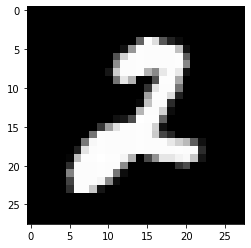

In [17]:
import matplotlib.pyplot as plt
images, labels = next(iter(train_loader))
plt.imshow(images[0].reshape(28,28), cmap="gray")

#### Model building
1. Defining components: <br/>
This step is done in the constructor, where you will define the layers that will be used accordingly in the next step.
2. Network flow: <br/>
This step is done in the forward function. Where you will get the input batch as an argument then you will use the defined layers in the previous step to define the flow of the network then you will return the output batch.


Pytorch is a dynamic framework, where you can use primitive python keywords with it.
You can use if and while statements. Also, it can accepts and returns more than one batch.

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 500)        
        # Write 3 lines to define 3 more linear layers.
        # 2 hidden layers with number of neurons numbers: 250 and 100
        # 1 output layer that should output 10 neurons, one for each class.
        self.fc2 = nn.Linear(500, 250)
        self.fc3 = nn.Linear(250, 100)
        self.fc4 = nn.Linear(100, 10)


    def forward(self, x):
        # the linear layers fc1, fc2, fc3, and fc4
        # accepts only flattened input (1D batches)
        # while the batch x is of size (batch, 28 * 28)
        # define one line to flatten the x to be of size (batch_sz, 28 * 28)
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return F.log_softmax(x, dim=1)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)

### Training loops
After that we should define the loops over tha batches and run the training on.

In [19]:
epochs = 10
lr = 0.01
momentum = 0.5
log_interval = 10

In [20]:
def train( model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item()))

In [21]:
def test( model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            # Do the same that was done in the previous function.
            # But without backprobagating the loss and without running the optimizers
            # As this function is only for test.
            # write 3 lines to transform the data to the device, get the output and compute the loss
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [22]:
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)


for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

torch.save(model.state_dict(), "mnist_model.pt")



Train Epoch: 1 [0/60000 (0%)]	Loss: 2.296403
Train Epoch: 1 [320/60000 (1%)]	Loss: 2.295671
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.296630
Train Epoch: 1 [960/60000 (2%)]	Loss: 2.286297
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.259093
Train Epoch: 1 [1600/60000 (3%)]	Loss: 2.235297
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.232859
Train Epoch: 1 [2240/60000 (4%)]	Loss: 2.188102
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.162278
Train Epoch: 1 [2880/60000 (5%)]	Loss: 2.119574
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.100663
Train Epoch: 1 [3520/60000 (6%)]	Loss: 2.084933
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.000745
Train Epoch: 1 [4160/60000 (7%)]	Loss: 1.817282
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.752432
Train Epoch: 1 [4800/60000 (8%)]	Loss: 1.537629
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.562723
Train Epoch: 1 [5440/60000 (9%)]	Loss: 1.467267
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.416112
Train Epoch: 1 [6080/60000 (10%)]	Loss: 1.052103
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.04